In [201]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import auc 
from sklearn.model_selection import KFold
from tqdm import tqdm
import pickle




In [202]:
df1 = pd.read_csv('data/ecommerce_customer_behavior_dataset.csv')
df2 = pd.read_csv('data/ecommerce_customer_behavior_dataset_v2.csv')

print(df1.columns.equals(df2.columns))
duplicates = set(df1['Customer_ID']).intersection(set(df2['Customer_ID']))
print(len(duplicates))

True
5000


In [203]:
# combine datasets
combined_df = pd.concat([df1, df2], ignore_index=True)

# Remove duplicate orders if any (very safe and recommended)
combined_df = combined_df.drop_duplicates(subset='Order_ID')

combined_df['Customer_ID'].nunique()  # number of unique customers

combined_df.isnull().sum()  # check for missing values
combined_df.dtypes

combined_df.head(100)



,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,Total_Amount,Payment_Method,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating
0,ORD_001337,CUST_01337,2023-01-01,27,Female,Bursa,Toys,54.28,1,0.00,54.28,Debit Card,Mobile,4,14,True,8,5
1,ORD_004885,CUST_04885,2023-01-01,42,Male,Konya,Toys,244.90,1,0.00,244.90,Credit Card,Mobile,11,3,True,3,3
2,ORD_004507,CUST_04507,2023-01-01,43,Female,Ankara,Food,48.15,5,0.00,240.75,Credit Card,Mobile,7,8,True,5,2
3,ORD_000645,CUST_00645,2023-01-01,32,Male,Istanbul,Electronics,804.06,1,229.28,574.78,Credit Card,Mobile,8,10,False,1,4
4,ORD_000690,CUST_00690,2023-01-01,40,Female,Istanbul,Sports,755.61,5,0.00,3778.05,Cash on Delivery,Desktop,21,10,True,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ORD_000928,CUST_00928,2023-01-11,39,Male,Istanbul,Beauty,41.11,1,0.00,41.11,Credit Card,Desktop,15,12,True,15,4
96,ORD_001597,CUST_01597,2023-01-12,42,Female,Bursa,Toys,185.71,4,54.51,688.33,Digital Wallet,Mobile,17,9,False,3,5
97,ORD_003464,CUST_03464,2023-01-12,47,Female,Adana,Toys,434.12,1,0.00,434.12,Credit Card,Desktop,26,11,False,9,4
98,ORD_004168,CUST_04168,2023-01-12,32,Male,Kayseri,Electronics,1860.25,1,119.50,1740.75,Credit Card,Mobile,22,7,False,6,4


In [204]:
def analyze_duplicates(df):
    """
    Comprehensive duplicate analysis
    """
    print("="*60)
    print("DUPLICATE ANALYSIS")
    print("="*60)
    
    # 1. Exact duplicates (all columns)
    exact_dups = df.duplicated().sum()
    print(f"\n1. EXACT DUPLICATES (all columns): {exact_dups}")
    
    # 2. Order ID duplicates
    order_dups = df['Order_ID'].duplicated().sum()
    print(f"\n2. DUPLICATE ORDER_IDs: {order_dups}")
    if order_dups > 0:
        print("   ⚠️ WARNING: Order_ID should be unique!")
        print(f"   Repeated Order_IDs: {df[df['Order_ID'].duplicated(keep=False)]['Order_ID'].unique()[:5]}")
    
    # 3. Customer duplicates on same date
    same_day_dups = df.duplicated(subset=['Customer_ID', 'Date'], keep=False).sum()
    print(f"\n3. SAME CUSTOMER + SAME DAY: {same_day_dups}")
    print(f"   (Normal if customer made multiple purchases same day)")
    
    # 4. Suspicious duplicates (same customer, date, amount)
    suspicious = df.duplicated(subset=['Customer_ID', 'Date', 'Total_Amount'], keep=False).sum()
    print(f"\n4. SUSPICIOUS DUPLICATES (Customer + Date + Amount): {suspicious}")
    if suspicious > 0:
        print("   ⚠️ These might be data entry errors!")
    
    # 5. Potential duplicates (same customer, date, product, amount)
    potential = df.duplicated(
        subset=['Customer_ID', 'Date', 'Product_Category', 'Total_Amount'], 
        keep=False
    ).sum()
    print(f"\n5. POTENTIAL DUPLICATES (Customer + Date + Product + Amount): {potential}")
    
    # 6. Check each key column
    print("\n6. DUPLICATE COUNTS BY KEY COLUMNS:")
    for col in ['Order_ID', 'Customer_ID', 'Date']:
        unique_count = df[col].nunique()
        total_count = len(df)
        dup_count = total_count - unique_count
        print(f"   {col}: {unique_count} unique / {total_count} total ({dup_count} duplicates)")
    
    return {
        'exact_duplicates': exact_dups,
        'order_id_duplicates': order_dups,
        'suspicious_duplicates': suspicious
    }

# Run the analysis
dup_stats = analyze_duplicates(combined_df)

DUPLICATE ANALYSIS

1. EXACT DUPLICATES (all columns): 0

2. DUPLICATE ORDER_IDs: 0

3. SAME CUSTOMER + SAME DAY: 214
   (Normal if customer made multiple purchases same day)

4. SUSPICIOUS DUPLICATES (Customer + Date + Amount): 0

5. POTENTIAL DUPLICATES (Customer + Date + Product + Amount): 0

6. DUPLICATE COUNTS BY KEY COLUMNS:
   Order_ID: 22049 unique / 22049 total (0 duplicates)
   Customer_ID: 5000 unique / 22049 total (17049 duplicates)
   Date: 451 unique / 22049 total (21598 duplicates)


In [205]:
# # try different churn definitions

# # Ensure Date column is datetime type
# combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# # Get the last date in your dataset
# last_date = combined_df['Date'].max()

# # Compute last purchase per customer
# customer_last_purchase = combined_df.groupby('Customer_ID')['Date'].max().reset_index()
# customer_last_purchase.columns = ['Customer_ID', 'Last_Purchase_Date']

# # Calculate days since last purchase
# customer_last_purchase['days_since_last_purchase'] = (last_date - customer_last_purchase['Last_Purchase_Date']).dt.days

# # Test multiple thresholds
# thresholds = [60, 90, 120, 180]

# for threshold in thresholds:
#     customer_last_purchase[f'Churn_{threshold}d'] = (
#         customer_last_purchase['days_since_last_purchase'] >= threshold
#     ).astype(int)
    
#     churn_rate = customer_last_purchase[f'Churn_{threshold}d'].mean() * 100
#     print(f"{threshold} days: {churn_rate:.1f}% churn rate")

# Implementing a single churn definition: 90 days
# A customer who hasn’t purchased in the last 90 days is considered churned (1), otherwise active (0).

# Ensure Date column is datetime type
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Get the last date in your dataset
last_date = combined_df['Date'].max()

# Compute last purchase per customer
customer_last_purchase = combined_df.groupby('Customer_ID')['Date'].max().reset_index()
customer_last_purchase.columns = ['Customer_ID', 'Last_Purchase_Date']

# Calculate days since last purchase
customer_last_purchase['days_since_last_purchase'] = (last_date - customer_last_purchase['Last_Purchase_Date']).dt.days

# Create churn column using 90-day threshold
churn_threshold = 90
customer_last_purchase['Churn_90d'] = (
    customer_last_purchase['days_since_last_purchase'] >= churn_threshold
).astype(int)

# print churn rate for 90 days
churn_rate = customer_last_purchase['Churn_90d'].mean() * 100
print(f"90 days: {churn_rate:.1f}% churn rate")

# Merge churn column back into transaction-level data
combined_df = combined_df.merge(
    customer_last_purchase[['Customer_ID', 'Churn_90d']],
    on='Customer_ID',
    how='left',
    suffixes=('', '_new')  # prevents _x/_y naming
)


90 days: 41.5% churn rate


In [206]:
# EDA

# DATA OVERVIEW
print("Shape of dataset:", combined_df.shape)
print("\nData types:\n", combined_df.dtypes)
print("\nMissing values:\n", combined_df.isnull().sum())
print("\nSummary statistics:\n", combined_df.describe())

Shape of dataset: (22049, 19)

Data types:
 Order_ID                            object
Customer_ID                         object
Date                        datetime64[ns]
Age                                  int64
Gender                              object
City                                object
Product_Category                    object
Unit_Price                         float64
Quantity                             int64
Discount_Amount                    float64
Total_Amount                       float64
Payment_Method                      object
Device_Type                         object
Session_Duration_Minutes             int64
Pages_Viewed                         int64
Is_Returning_Customer                 bool
Delivery_Time_Days                   int64
Customer_Rating                      int64
Churn_90d                            int64
dtype: object

Missing values:
 Order_ID                    0
Customer_ID                 0
Date                        0
Age              

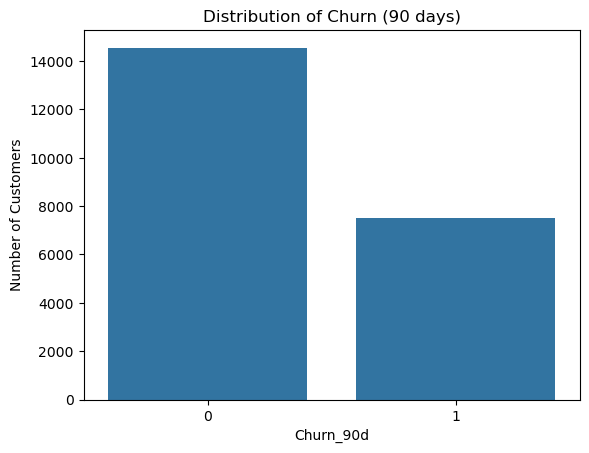

In [207]:
# Bar plot for churn distribution
sns.countplot(data=combined_df, x='Churn_90d')
plt.title("Distribution of Churn (90 days)")
plt.xlabel("Churn_90d")
plt.ylabel("Number of Customers")
plt.show()

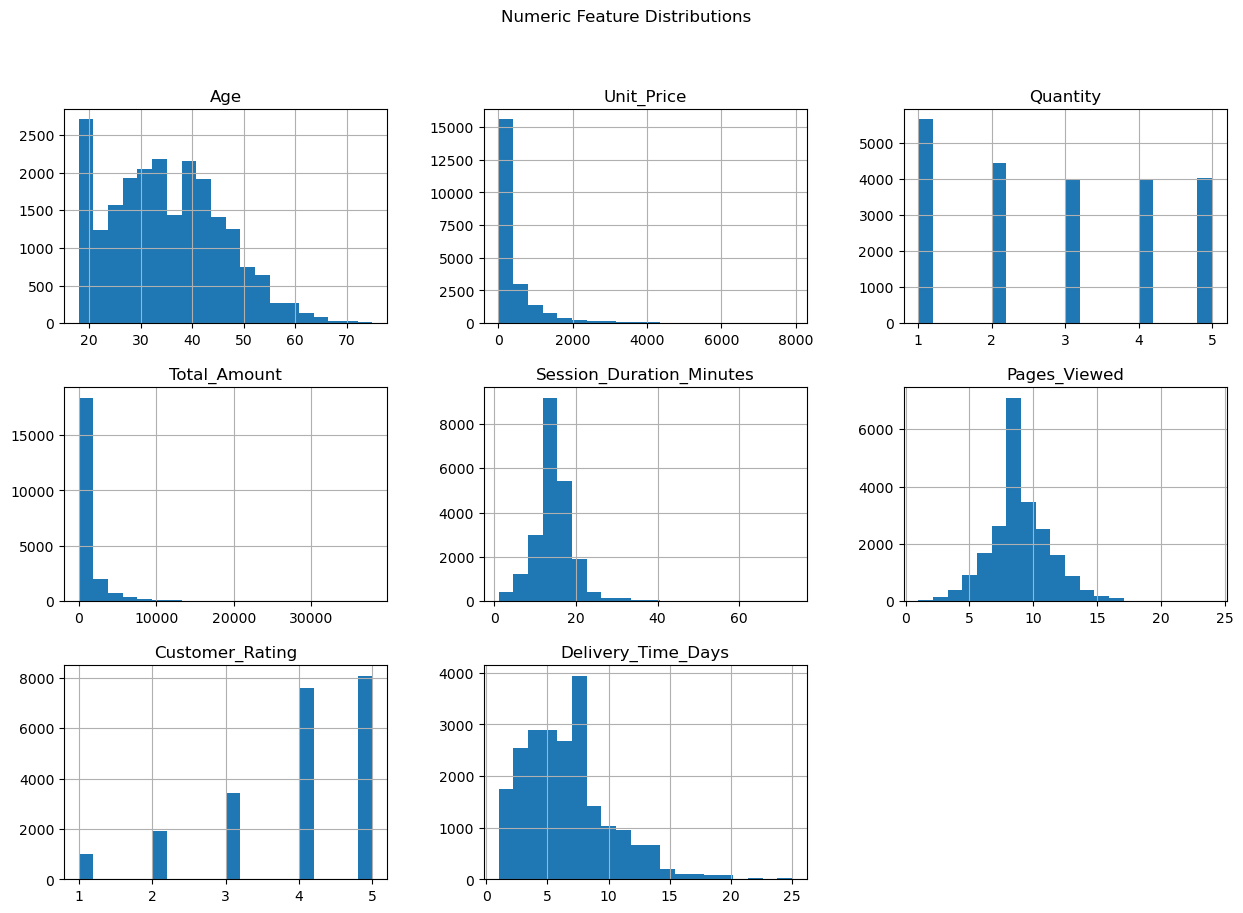

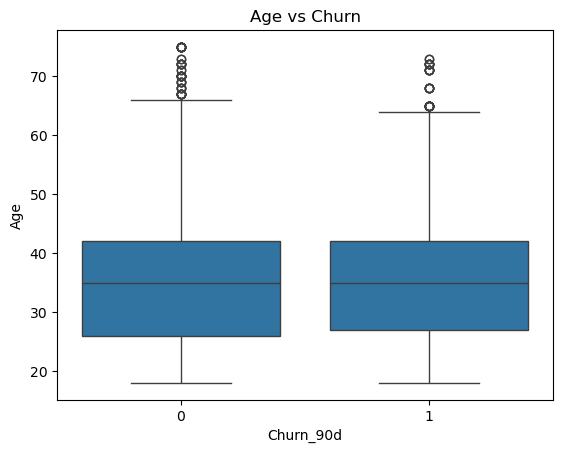

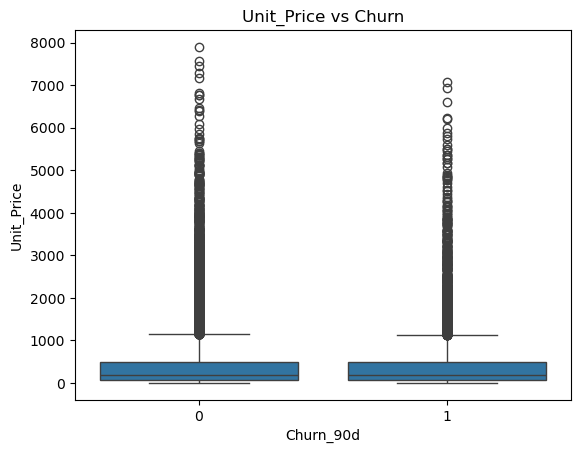

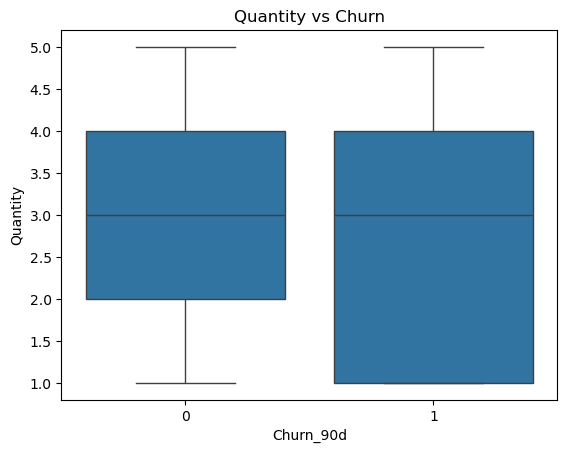

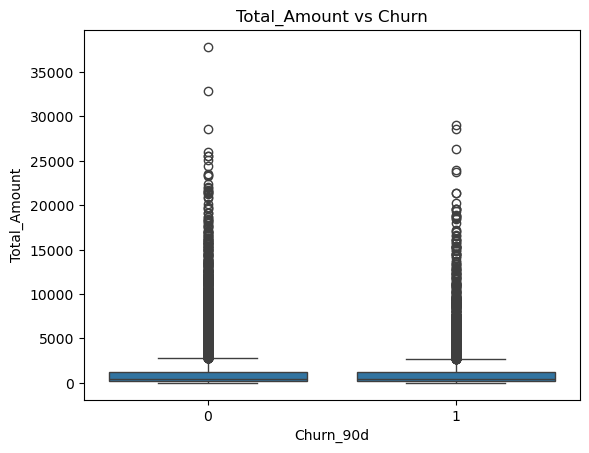

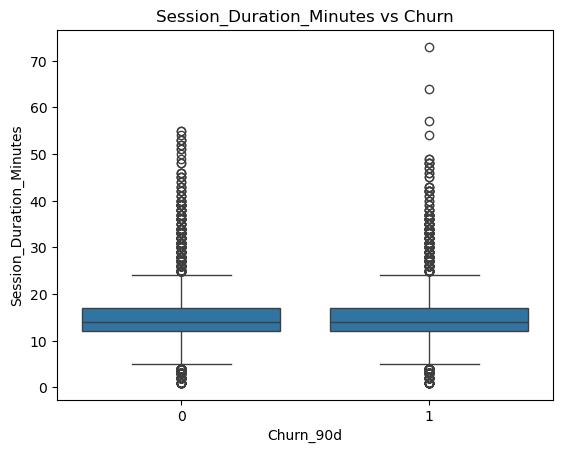

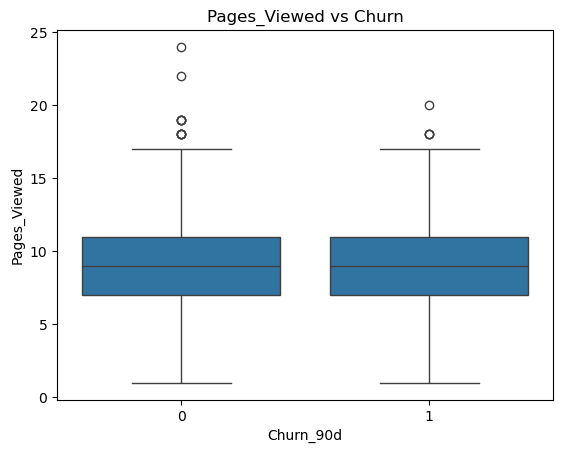

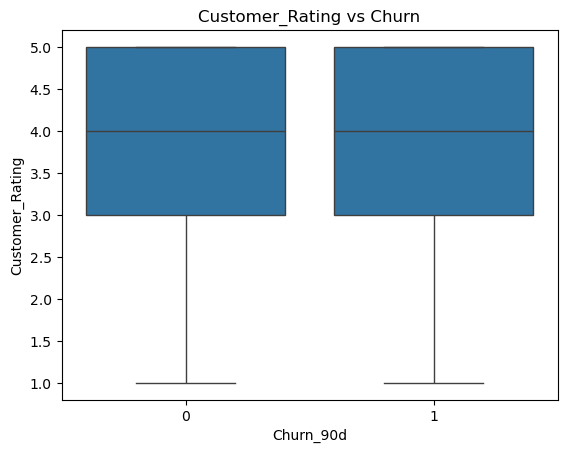

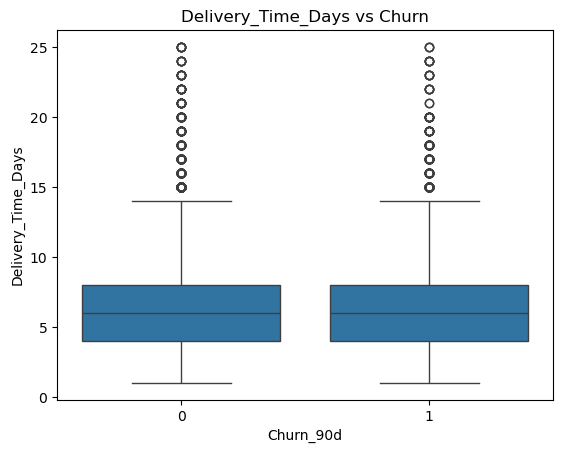

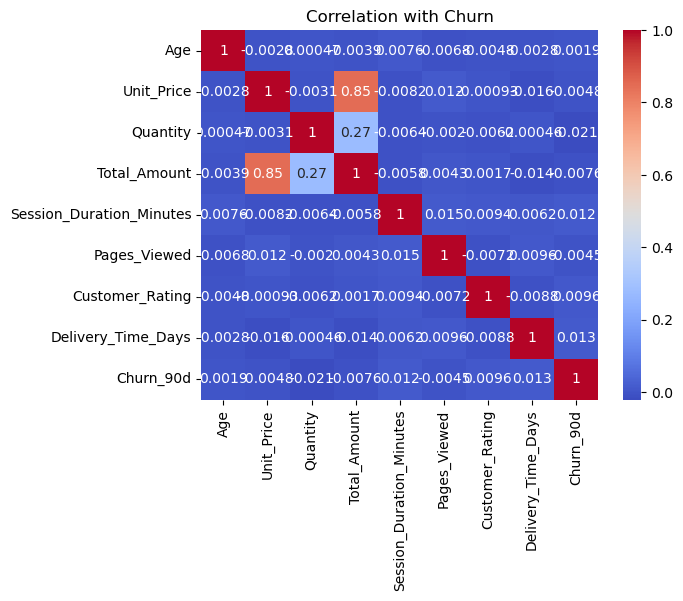

In [208]:
# NUMERIC FEATURE ANALYSIS
numeric_cols = ['Age', 'Unit_Price', 'Quantity', 'Total_Amount', 
                'Session_Duration_Minutes', 'Pages_Viewed', 'Customer_Rating', 'Delivery_Time_Days']

# Histograms
combined_df[numeric_cols].hist(bins=20, figsize=(15,10))
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Boxplots for numeric features vs churn
for col in numeric_cols:
    sns.boxplot(x='Churn_90d', y=col, data=combined_df)
    plt.title(f"{col} vs Churn")
    plt.show()

# Correlation heatmap
corr = combined_df[numeric_cols + ['Churn_90d']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation with Churn")
plt.show()


Churn rate by Gender:
Gender
Other     0.387387
Male      0.343417
Female    0.334894
Name: Churn_90d, dtype: float64


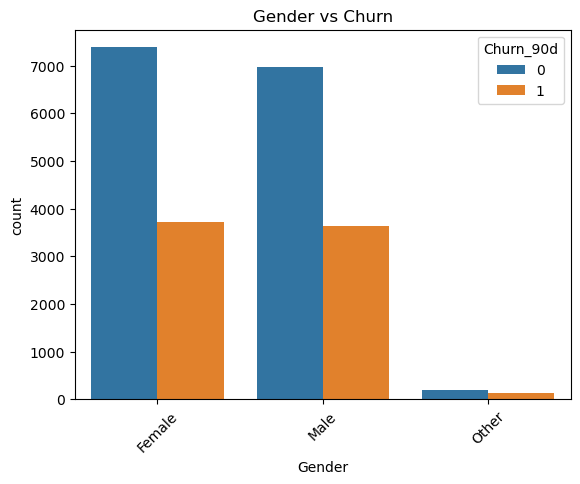


Churn rate by City:
City
Eskisehir    0.363537
Gaziantep    0.358355
Istanbul     0.356138
Ankara       0.339880
Adana        0.333920
Bursa        0.333784
Izmir        0.331213
Antalya      0.330247
Konya        0.315936
Kayseri      0.296931
Name: Churn_90d, dtype: float64


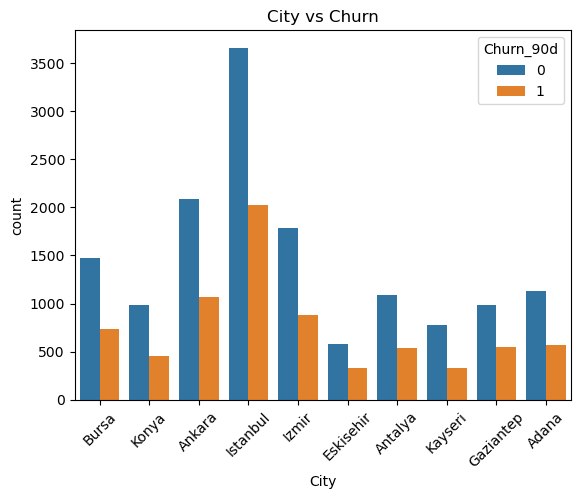


Churn rate by Device_Type:
Device_Type
Mobile     0.341060
Desktop    0.339068
Tablet     0.335035
Name: Churn_90d, dtype: float64


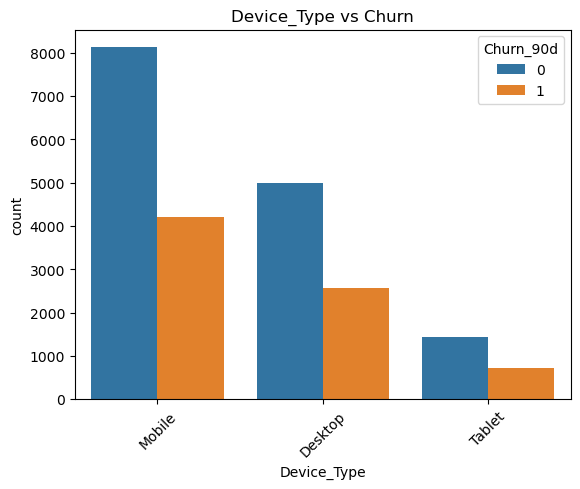


Churn rate by Payment_Method:
Payment_Method
Cash on Delivery    0.359155
Digital Wallet      0.344258
Debit Card          0.340315
Credit Card         0.337569
Bank Transfer       0.329081
Name: Churn_90d, dtype: float64


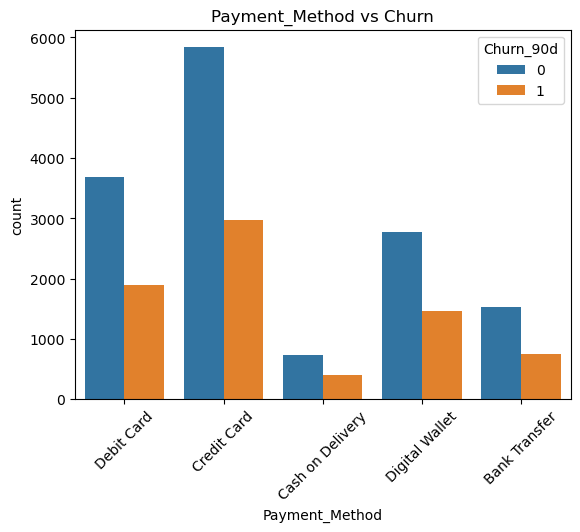


Churn rate by Product_Category:
Product_Category
Home & Garden    0.344275
Electronics      0.342847
Fashion          0.341673
Food             0.341293
Beauty           0.340628
Toys             0.340370
Sports           0.337221
Books            0.330617
Name: Churn_90d, dtype: float64


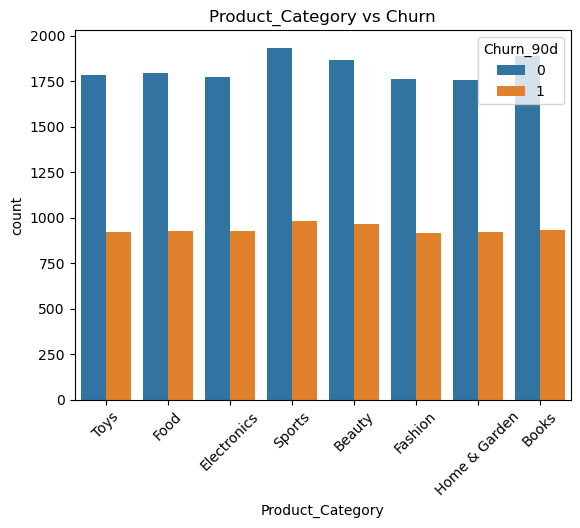


Churn rate by Is_Returning_Customer:
Is_Returning_Customer
False    0.413930
True     0.323257
Name: Churn_90d, dtype: float64


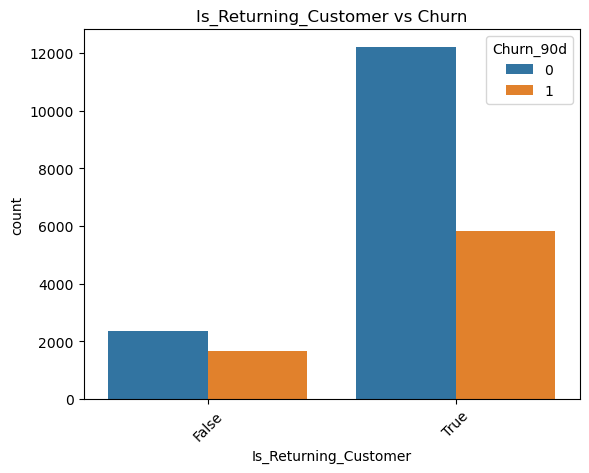

In [209]:
# CATEGORICAL FEATURE ANALYSIS 
categorical_cols = ['Gender', 'City', 'Device_Type', 'Payment_Method', 'Product_Category', 'Is_Returning_Customer']

for col in categorical_cols:
    print(f"\nChurn rate by {col}:")
    print(combined_df.groupby(col)['Churn_90d'].mean().sort_values(ascending=False))
    
    sns.countplot(data=combined_df, x=col, hue='Churn_90d')
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.show()

In [210]:
df_full_train, df_test = train_test_split(combined_df, test_size=0.2, random_state=1)

# get validation dataset

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) 

# make indices not to be shuffles

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_train), len(df_val), len(df_test)

(13229, 4410, 4410)

In [211]:
# get target variable
y_train = df_train.Churn_90d.values
y_val = df_val.Churn_90d.values
y_test = df_test.Churn_90d.values

# delete target variable from dataframes

del df_train['Churn_90d']
del df_val['Churn_90d']
del df_test['Churn_90d']

In [212]:
df_train.shape, df_val.shape, df_test.shape

((13229, 18), (4410, 18), (4410, 18))

In [213]:
global_churn = df_full_train.Churn_90d.mean()


In [214]:
# FEATURE IMPORTANCE: CHURN RATE AND RISK RATIO

# CHURN RATE
# RISK  RATIO
# MUTUTAL INFORMATION



In [215]:
numeric_cols = ['Age', 'Unit_Price', 'Quantity', 'Total_Amount', 
                'Session_Duration_Minutes', 'Pages_Viewed', 'Customer_Rating', 'Delivery_Time_Days']

categorical_cols = ['Gender', 'City', 'Device_Type', 'Payment_Method', 'Product_Category', 'Is_Returning_Customer']


In [216]:
for col in categorical_cols:
    df_group = df_full_train.groupby(col).Churn_90d.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk_ratio'] = df_group['mean'] / global_churn
    print(f'\nColumn: {col}')
    display(df_group)


Column: Gender


,mean,count,diff,risk_ratio
Gender,,,,
Female,0.335610,8933,-0.005396,0.984176
Male,0.345371,8446,0.004365,1.012800
Other,0.384615,260,0.043610,1.127885



Column: City


,mean,count,diff,risk_ratio
City,,,,
Adana,0.325018,1363,-0.015987,0.953117
Ankara,0.344814,2526,0.003808,1.011168
Antalya,0.342879,1292,0.001874,1.005494
Bursa,0.337472,1772,-0.003534,0.989637
Eskisehir,0.379781,732,0.038776,1.113710
Gaziantep,0.364003,1239,0.022998,1.067440
Istanbul,0.353135,4545,0.012130,1.035570
Izmir,0.334112,2140,-0.006894,0.979785
Kayseri,0.289385,895,-0.051620,0.848624



Column: Device_Type


,mean,count,diff,risk_ratio
Device_Type,,,,
Desktop,0.337849,6053,-0.003157,0.990743
Mobile,0.343285,9881,0.002279,1.006684
Tablet,0.339003,1705,-0.002003,0.994127



Column: Payment_Method


,mean,count,diff,risk_ratio
Payment_Method,,,,
Bank Transfer,0.343750,1792,0.002744,1.008048
Cash on Delivery,0.349515,927,0.008509,1.024952
Credit Card,0.337697,7027,-0.003308,0.990298
Debit Card,0.337748,4530,-0.003257,0.990448
Digital Wallet,0.348498,3363,0.007493,1.021972



Column: Product_Category


,mean,count,diff,risk_ratio
Product_Category,,,,
Beauty,0.338047,2263,-0.002959,0.991323
Books,0.340463,2244,-0.000542,0.998410
Electronics,0.340553,2170,-0.000453,0.998672
Fashion,0.350472,2120,0.009466,1.027759
Food,0.340149,2152,-0.000857,0.997487
Home & Garden,0.339078,2147,-0.001928,0.994346
Sports,0.341505,2366,0.000499,1.001463
Toys,0.338080,2177,-0.002926,0.991420



Column: Is_Returning_Customer


,mean,count,diff,risk_ratio
Is_Returning_Customer,,,,
False,0.411160,3208,0.070154,1.205726
True,0.325411,14431,-0.015595,0.954267


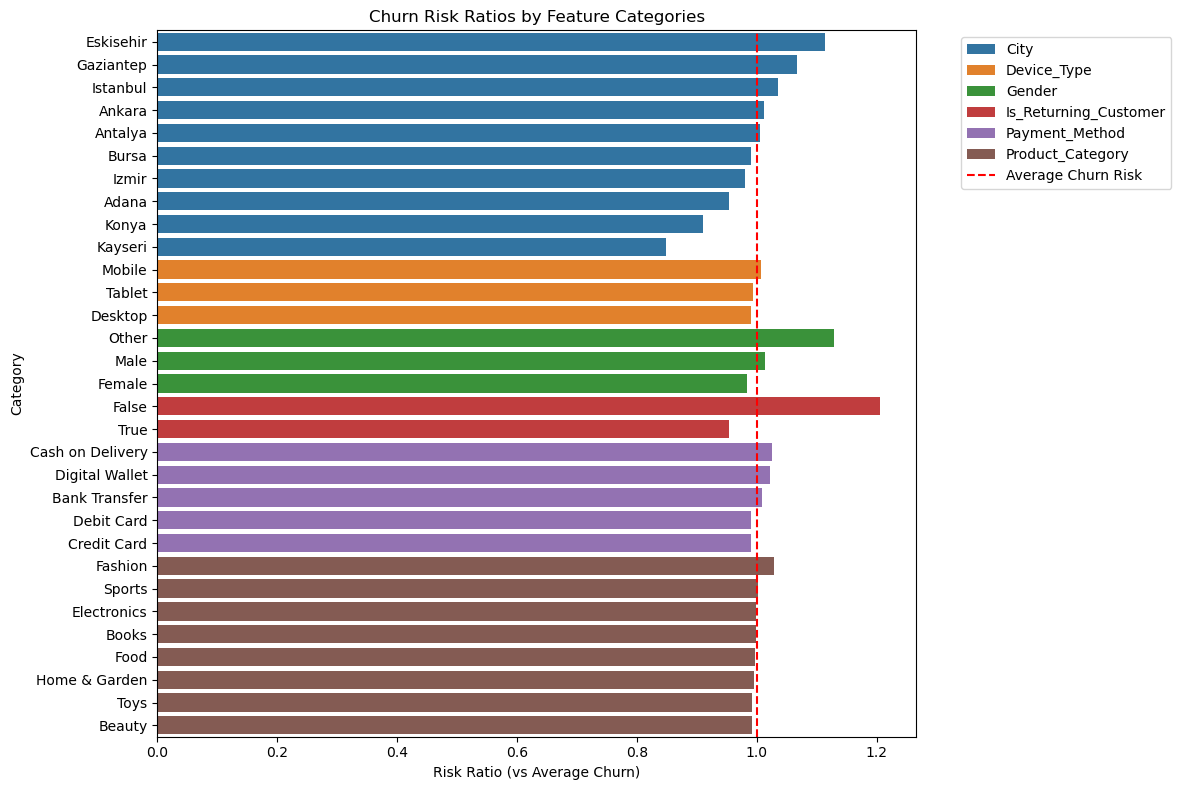

In [217]:
risk_ratios = []

for col in categorical_cols:
    group = df_full_train.groupby(col)['Churn_90d'].mean().reset_index()
    group['risk_ratio'] = group['Churn_90d'] / global_churn
    group['feature'] = col
    group.rename(columns={col: 'category'}, inplace=True)
    risk_ratios.append(group[['feature', 'category', 'risk_ratio']])

# Combine all
risk_df = pd.concat(risk_ratios, ignore_index=True)

# Sort within each feature for better visualization
risk_df.sort_values(['feature', 'risk_ratio'], ascending=[True, False], inplace=True)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='risk_ratio', y='category', hue='feature', data=risk_df, dodge=False)
plt.axvline(1, color='red', linestyle='--', label='Average Churn Risk')
plt.title('Churn Risk Ratios by Feature Categories')
plt.xlabel('Risk Ratio (vs Average Churn)')
plt.ylabel('Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [218]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.Churn_90d)

In [219]:
df_full_train[categorical_cols].apply(mutual_info_churn_score).sort_values(ascending=False)

Is_Returning_Customer    0.002381
City                     0.000815
Gender                   0.000114
Payment_Method           0.000050
Product_Category         0.000030
Device_Type              0.000015
dtype: float64

In [220]:
# Train model:
dv = DictVectorizer(sparse=False)
train_dicts = (df_train[categorical_cols + numeric_cols].to_dict(orient='records'))
x_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical_cols + numeric_cols].to_dict(orient='records')
x_val = dv.transform(val_dicts)

# Train the model

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42, class_weight='balanced')

model.fit(x_train, y_train)
y_pred = model.predict_proba(x_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()  # accuracy

0.5612244897959183

In [221]:
# evaluate prediction for different thresholds i.e from 0 to 21 
thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    score = accuracy_score(y_val, (y_pred >= t).astype(int))
    print('%.2f %.3f' % (t, score))
    scores.append(score)


0.00 0.334
0.05 0.334
0.10 0.334
0.15 0.334
0.20 0.334
0.25 0.334
0.30 0.334
0.35 0.334
0.40 0.336
0.45 0.386
0.50 0.561
0.55 0.624
0.60 0.652
0.65 0.664
0.70 0.666
0.75 0.666
0.80 0.666
0.85 0.666
0.90 0.666
0.95 0.666
1.00 0.666


In [222]:
#CONFUSION TABLE
# A way of looking at error and prediction scores

t = 0.5

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)


predicted_positive = (y_pred >= t)
predictive_negative = (y_pred < t)

tp = (predicted_positive & actual_positive).sum()
tn = (predictive_negative & actual_negative).sum()

fp = (predicted_positive & actual_negative).sum()
fn = (predictive_negative & actual_positive).sum()
tp, tn, fp, fn

(552, 1923, 1016, 919)

In [223]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])

(confusion_matrix  / confusion_matrix.sum()).round(2) 

array([[0.44, 0.23],
       [0.21, 0.13]])

In [224]:

thresholds = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
for t in thresholds:
    churn_decision = (y_pred >= t).astype(int)
    precision = precision_score(y_val, churn_decision)
    recall = recall_score(y_val, churn_decision)
    f1 = f1_score(y_val, churn_decision)
    print(f"Threshold {t:.2f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


Threshold 0.10: Precision=0.334, Recall=1.000, F1=0.500
Threshold 0.20: Precision=0.334, Recall=1.000, F1=0.500
Threshold 0.25: Precision=0.334, Recall=1.000, F1=0.500
Threshold 0.30: Precision=0.334, Recall=1.000, F1=0.500
Threshold 0.40: Precision=0.334, Recall=0.993, F1=0.499
Threshold 0.50: Precision=0.352, Recall=0.375, F1=0.363


Text(0, 0.5, 'True Positive Rate as TPR')

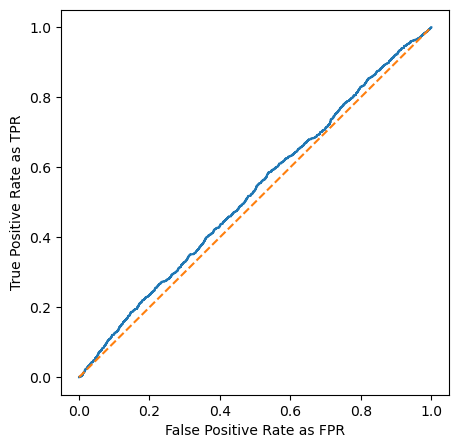

In [225]:
# ROC CURVE AND AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('False Positive Rate as FPR')
plt.ylabel('True Positive Rate as TPR')

In [226]:
auc_value = auc(fpr, tpr)
roc_auc_score(y_val, y_pred)


0.526013532815099

In [227]:
# CROSS VALIDATION: A WAY TO ESTIMATE MODEL PERFORMANCE ON DIFFERENT DATASETS
# K-FOLD CROSS VALIDATION
# Evaluating the same model on different subset  of data
# Getting the average prediction and the spread within the predictions

def train(df_train, y_train, C=1.0):
    
    dicts = (df_train[categorical_cols + numeric_cols].to_dict(orient='records'))
    
    dv = DictVectorizer(sparse=False)
    x_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(x_train, y_train)
    return dv, model

In [228]:
dv, model = train(df_train,y_train, C=0.001)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [229]:
def predict(df, dv, model):
    dicts = (df[categorical_cols + numeric_cols].to_dict(orient='records'))
    x = dv.transform(dicts)
    y_pred = model.predict_proba(x)[:, 1]
    return y_pred

In [230]:
y_pred = predict(df_val, dv, model)

In [231]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx  in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_full_train.Churn_90d.iloc[train_idx].values
        y_val = df_full_train.Churn_90d.iloc[val_idx].values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

C=0.001 0.533 +- 0.013


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C=0.01 0.538 +- 0.014


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C=0.1 0.536 +- 0.014


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C=0.5 0.538 +- 0.011


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C=1 0.539 +- 0.014


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C=5 0.538 +- 0.012


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C=10 0.538 +- 0.012


In [232]:
dv, model = train(df_full_train, df_full_train.Churn_90d.values, C=1.0)
y_pred = predict(df_test, dv, model)
    
auc = roc_auc_score(y_test, y_pred)

auc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5471363267337498

In [233]:
output_file = f'model_C={C}.bin'
output_file

'model_C=10.bin'

In [234]:
#save  model and save it to a file

with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [235]:
#Load the model from the file

with open(output_file, 'rb') as f_in:
    dv,  model =    pickle.load(f_in)

In [238]:
customer = {
    'Age':32,
    'Gender': 'Male',
    'City': 'Istanbul',
    'Device_Type': 'Mobile',
    'Payment_Method': 'Credit Card',
    'Product_Category': 'Electronics',
    'Is_Returning_Customer': 'False',
    'Unit_Price': 804.06,
    'Quantity': 1,
    'Total_Amount': 574.78,
    'Session_Duration_Minutes': 8,
    'Pages_Viewed': 10,
    'Customer_Rating': 4,
    'Delivery_Time_Days':  1,
    'Discount_Amount': 229.28
}

In [239]:
X = dv.transform([customer])

model.predict_proba(X)[0, 1]  # probability of churn

0.43962244306260145